In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from pyDOE import lhs

np.random.seed(1234)

In [2]:
print(torch.cuda.is_available())  # Should return True
print(torch.cuda.current_device())  # Should return an integer (GPU index)
print(torch.cuda.get_device_name(torch.cuda.current_device()))  # GPU name

True
0
NVIDIA GeForce RTX 2060


In [3]:
# CUDA support
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")

print(f"Using device: {device}")

torch.backends.cudnn.benchmark = True

Using device: cuda


In [4]:
class DNN(nn.Module):
    def __init__(self, layers):
        super(DNN, self).__init__()
        modules = []
        for i in range(len(layers) - 2):  # Exclude last layer for activation
            modules.append(nn.Linear(layers[i], layers[i+1]))
            modules.append(nn.Tanh())
        modules.append(nn.Linear(layers[-2], layers[-1]))  # Last layer (no activation)
        self.network = nn.Sequential(*modules)

        for layer in self.network:
            if isinstance(layer, nn.Linear):
                nn.init.xavier_uniform_(layer.weight)
                if layer.bias is not None:
                    nn.init.zeros_(layer.bias)

    def forward(self, x):
        return self.network(x)

In [5]:
lbfgs_lr = 0.001
adam_lr = 0.001

In [ ]:
class PINN():
    def __init__(self, X, Y, layers, s0, E, h, l, r, nu):
        self.x_dom = torch.tensor(X['dom'], requires_grad=True).float().to(device).view(-1, 1)
        self.y_dom = torch.tensor(Y['dom'], requires_grad=True).float().to(device).view(-1, 1)

        self.x_left = torch.tensor(X['left'], requires_grad=True).float().to(device).view(-1, 1)
        self.y_left = torch.tensor(Y['left'], requires_grad=True).float().to(device).view(-1, 1)
        
        self.x_top = torch.tensor(X['top'], requires_grad=True).float().to(device).view(-1, 1)
        self.y_top = torch.tensor(Y['top'], requires_grad=True).float().to(device).view(-1, 1)

        self.x_right = torch.tensor(X['right'], requires_grad=True).float().to(device).view(-1, 1)
        self.y_right = torch.tensor(Y['right'], requires_grad=True).float().to(device).view(-1, 1)

        self.x_down = torch.tensor(X['down'], requires_grad=True).float().to(device).view(-1, 1)
        self.y_down = torch.tensor(Y['down'], requires_grad=True).float().to(device).view(-1, 1)

        self.x_hole = torch.tensor(X['hole'], requires_grad=True).float().to(device).view(-1, 1)
        self.y_hole = torch.tensor(Y['hole'], requires_grad=True).float().to(device).view(-1, 1)

        self.s_r = s0
        self.E = E
        self.nu = nu

        self.h = h
        self.l = l
        self.r = r

        self.w_pde = 1
        self.w_bc = 1

        # DNN
        self.dnn = DNN(layers).to(device)

        # Optimizer
        self.optimizer_lbfgs = torch.optim.LBFGS(
            self.dnn.parameters(),
            lr=lbfgs_lr,
            max_iter=50000,
            max_eval=50000,
            history_size=50,
            tolerance_grad=1e-5,
            tolerance_change=1.0 * np.finfo(float).eps,
            line_search_fn="strong_wolfe"
        )

        self.optimizer_adam = torch.optim.Adam(self.dnn.parameters(), lr=adam_lr)
        self.scheduler = torch.optim.lr_scheduler.StepLR(self.optimizer_adam, step_size=2000, gamma=0.5)
        self.iter = 0

    def model_value(self, x, y):
        out = self.dnn(torch.cat((x, y), dim=1))
        u = out[:,0].view(-1, 1)
        v = out[:,1].view(-1, 1)
        sxx = out[:,2].view(-1, 1)
        syy = out[:,3].view(-1, 1)
        sxy = out[:,4].view(-1, 1)
        return u, v, sxx, syy, sxy

    def bc_loss(self, xl, yl, xt, yt, xr, yr, xd, yd, xh, yh):
        u_l, v_l, _, _, _ = self.model_value(xl, yl)
        _, _, _, syy_t, sxy_t = self.model_value(xt, yt)
        _, _, sxx_r, _, sxy_r = self.model_value(xr, yr)
        _, _, _, syy_d, sxy_d = self.model_value(xd, yd)
        _, _, sxx_h, syy_h, sxy_h = self.model_value(xh, yh)

        b = torch.mean(torch.pow(u_l, 2))
        b += torch.mean(torch.pow(v_l, 2))

        b += torch.mean(torch.pow(syy_t, 2))
        b += torch.mean(torch.pow(sxy_t, 2))

        b += torch.mean(torch.pow(sxx_r - self.s_r, 2))
        b += torch.mean(torch.pow(sxy_r, 2))

        b += torch.mean(torch.pow(syy_d, 2))
        b += torch.mean(torch.pow(sxy_d, 2))

        n = -1 * torch.stack([(xh-self.l)/self.r, (yh-self.h)/self.r], dim=1)
        s = torch.cat([
            torch.cat([sxx_h, sxy_h], dim=1).unsqueeze(1),  # First row (xx, xy)
            torch.cat([sxy_h, syy_h], dim=1).unsqueeze(1)   # Second row (xy, yy)
        ], dim=1)

        t = torch.bmm(s, n)
        b += torch.mean(torch.pow(t, 2))

        return b

    
    def loss_func(self):
        bc = self.bc_loss(
            self.x_left, self.y_left, 
            self.x_top, self.y_top, 
            self.x_right, self.y_right, 
            self.x_down, self.y_down, 
            self.x_hole, self.y_hole
        )
        return bc


    def lbfgs_func(self):
        loss = self.loss_func()
        self.optimizer_lbfgs.zero_grad()
        loss.backward()

        if self.iter % 100 == 0:
            print(f"Iter: {self.iter}, Loss: {'{:e}'.format(loss.item())}")
        self.iter += 1
        return loss
    
    def train(self, epochs=1000):
        self.dnn.train()
        for epoch in range(epochs):
            loss = self.loss_func()

            self.optimizer_adam.zero_grad()
            loss.backward()
            self.optimizer_adam.step()
            self.scheduler.step()

            if epoch % 100 == 0:
                print(f"Epoch {epoch}, Loss: {'{:e}'.format(loss.item())}")
        self.optimizer_lbfgs.step(self.lbfgs_func)

    def predict(self, x, y):
        x = torch.tensor(x).float().to(device)
        y = torch.tensor(y).float().to(device)

        self.dnn.eval()
        u, v, sxx, syy, sxy = self.model_value(x, y)
        u = u.detach().cpu().numpy()
        v = v.detach().cpu().numpy()
        sxx = sxx.detach().cpu().numpy()
        syy = syy.detach().cpu().numpy()
        sxy = sxy.detach().cpu().numpy()
        return u, v, sxx, syy, sxy

In [7]:
def generate_points(pd, pb, l, h, r):
    a = l / 2
    b = h / 2

    area = r**2 * np.pi
    p_new = int(pd * (1+area)) # Increase amount of points with percantage of circle covering

    dom = lhs(2, p_new)
    mask = np.sqrt((dom[:,0]*l - a)**2 + (dom[:,1]*h - b)**2) >= r
    dom = dom[mask]
    dom_x = dom[:,0] * l
    dom_y = dom[:,1] * h

    left_x = np.zeros(pb)
    left_y = lhs(1, pb) * h

    top_x = lhs(1, pb) * l
    top_y = np.ones(pb) * h

    right_x = np.ones(pb) * l
    right_y = lhs(1, pb) * h

    down_x = lhs(1, pb) * l
    down_y = np.zeros(pb)

    theta = np.random.uniform(0, 2*np.pi, pb)
    hole_x = a + r*np.cos(theta)
    hole_y = b + r*np.sin(theta)

    X = {'dom': dom_x, 'left': left_x, 'top': top_x, 'right': right_x, 'down': down_x, 'hole': hole_x}
    Y = {'dom': dom_y, 'left': left_y, 'top': top_y, 'right': right_y, 'down': down_y, 'hole': hole_y}
    return X, Y

In [16]:
l = 1
h = 1
r = 0.2
s0 = 0.1
E = 1
nu = 0.3


X, Y = generate_points(1000, 100, l, h, r)

nodes = 64
layers = [2] + 6 * [nodes] + [5]

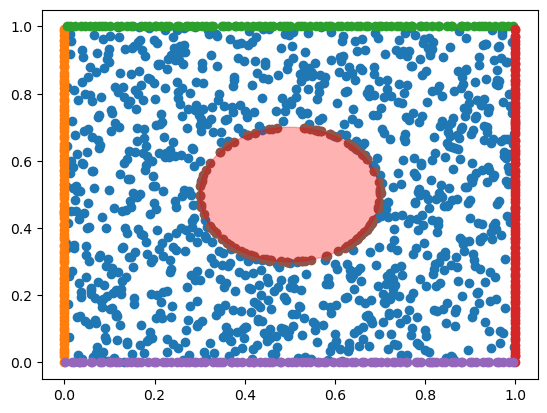

In [9]:
circle = plt.Circle((l/2, h/2), r, color='red', alpha=0.3)


figure, ax = plt.subplots()
ax.scatter(X['dom'], Y['dom'])
ax.scatter(X['left'], Y['left'])
ax.scatter(X['top'], Y['top'])
ax.scatter(X['right'], Y['right'])
ax.scatter(X['down'], Y['down'])
ax.scatter(X['hole'], Y['hole'])

ax.add_patch(circle)

plt.show()

In [17]:
model = PINN(X, Y, layers, s0, E, nu)

In [18]:
model.train(4000)

Epoch 0, Loss: 1.049819e-01
Epoch 100, Loss: 2.285512e-04
Epoch 200, Loss: 2.229177e-04
Epoch 300, Loss: 2.181304e-04
Epoch 400, Loss: 2.133701e-04
Epoch 500, Loss: 2.087940e-04
Epoch 600, Loss: 2.044186e-04
Epoch 700, Loss: 2.001750e-04
Epoch 800, Loss: 1.959375e-04
Epoch 900, Loss: 1.915767e-04
Epoch 1000, Loss: 1.870677e-04
Epoch 1100, Loss: 1.826046e-04
Epoch 1200, Loss: 1.914170e-04
Epoch 1300, Loss: 1.789571e-04
Epoch 1400, Loss: 1.747566e-04
Epoch 1500, Loss: 1.721893e-04
Epoch 1600, Loss: 1.782003e-04
Epoch 1700, Loss: 1.714236e-04
Epoch 1800, Loss: 1.687696e-04
Epoch 1900, Loss: 1.668208e-04
Epoch 2000, Loss: 2.044120e-04
Epoch 2100, Loss: 1.658903e-04
Epoch 2200, Loss: 1.628656e-04
Epoch 2300, Loss: 2.245163e-04
Epoch 2400, Loss: 1.620750e-04
Epoch 2500, Loss: 1.592757e-04
Epoch 2600, Loss: 1.718727e-04
Epoch 2700, Loss: 1.585322e-04
Epoch 2800, Loss: 1.546622e-04
Epoch 2900, Loss: 1.570840e-04
Epoch 3000, Loss: 5.965912e-04
Epoch 3100, Loss: 1.552784e-04
Epoch 3200, Loss: 1.

In [74]:
x1, y1 = generate_points(1000, 100, l, h, r)

x = x1['left'].reshape(-1, 1)
y = y1['left'].reshape(-1, 1)
print(x.shape)
print(y.shape)

u, v, sxx, syy, sxy = model.predict(x, y)

(100, 1)
(100, 1)


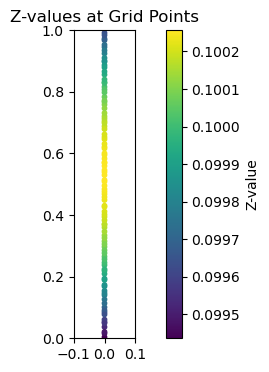

In [75]:
plt.figure(figsize=(8, 4))
sc = plt.scatter(x, y, c=sxx, cmap='viridis', s=10)
plt.colorbar(sc, label="Z-value")
plt.title("Z-values at Grid Points")
plt.xlim(-0.1, 0.1)
plt.ylim(0, h)
plt.gca().set_aspect('equal')
plt.show()

In [ ]:

x0 = x[0]
y0 = y[0]
sxx0 = sxx[0][0]
syy0 = syy[0][0]
sxy0 = sxy[0][0]

radius = np.sqrt(x0**2 + y0**2)
n = np.array([x0/radius, y0/radius])

s = np.array([[sxx0, sxy0], [sxy0, syy0]])
# print(radius)
# print(n)
# print(n.shape)

# print(s)
# print(s.shape)

c = np.matmul(s, n)
print(c)
print(c.shape)


sxx_h = torch.tensor(sxx).float()
syy_h = torch.tensor(syy).float()
sxy_h = torch.tensor(sxy).float()

# print(xh, yh)
xt = torch.tensor(x).float()
yt = torch.tensor(y).float()
radius = torch.sqrt(xt**2 + yt**2)

n = torch.stack([xt/radius, yt/radius], dim=1)

s = torch.cat([
    torch.cat([sxx_h, sxy_h], dim=1).unsqueeze(1),  # First row (xx, xy)
    torch.cat([sxy_h, syy_h], dim=1).unsqueeze(1)   # Second row (xy, yy)
], dim=1)

# print(s)
# print(s.shape)

t = torch.bmm(s, n)
print(t[0])
print(t.shape)

[[ 0.00158158]
 [-0.00037898]]
(2, 1)
tensor([[ 0.0016],
        [-0.0004]])
torch.Size([100, 2, 1])
tensor([[2.5014e-06],
        [1.4362e-07]])
2.4964e-06
